<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/public_school_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 公立学校スコア
- input
    - public_school_master.csv
        - 小学校の位置とレーティング
        - 中学校の位置とレーティング
        - 中学校の位置とレーティング
- output
    - public_school_score.csv
        - 小学校スコア
        - 中学校スコア
        - 幼稚園スコア

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
output_score_file = 'public_school_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


### 学校

In [7]:
df_school_master = pd.read_csv(os.path.join(DIR_NAME, 'public_school_master.csv'))[['学校番号', '施設分類', '市区町村名', '名称', '緯度', '経度', 'rating']]
df_school_master['学校番号'] = df_school_master['学校番号'].astype(str)
print(df_school_master.shape)

(1363, 7)


In [8]:
# レーティングが0.0の学校は、区ごとの平均で埋める
mean_rating = df_school_master.groupby(['施設分類', '市区町村名'])['rating'].transform('mean').round(2)
df_school_master.loc[df_school_master['rating'] == 0, 'rating'] = mean_rating

In [9]:
df_school_master.head()

,学校番号,施設分類,市区町村名,名称,緯度,経度,rating
0,101150,幼稚園,千代田区,千代田区立麹町幼稚園,35.685691,139.740164,1.56
1,101160,幼稚園,千代田区,千代田区立九段幼稚園,35.690666,139.741195,1.56
2,101170,幼稚園,千代田区,千代田区立番町幼稚園,35.687629,139.733426,5.00
3,101190,幼稚園,千代田区,千代田区立お茶の水幼稚園,35.697445,139.748569,4.00
4,101200,幼稚園,千代田区,千代田区立千代田幼稚園,35.693169,139.768274,1.56


In [10]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].reset_index(drop=True)
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'min_param':
            # 最小の距離の時の他のパラメータを返す
            min_idx = dist.idxmin()
            if np.isnan(min_idx):
                val = np.NaN
            else:
                val = _df_cat.iloc[min_idx][param]
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

### スコア

In [11]:
%%time
# 一番近い施設の距離
df_pop_master['小学校(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '小学校', 'min')
# 一番近い施設の距離
df_pop_master['中学校(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '中学校', 'min')
# 一番近い施設の距離
df_pop_master['幼稚園(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '幼稚園', 'min')
# 最寄りの小学校
df_pop_master['小学校(学校番号)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '小学校', 'min_param', '学校番号')
# 最寄りの中学校
df_pop_master['中学校(学校番号)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '中学校', 'min_param', '学校番号')
# 最寄りの幼稚園
df_pop_master['幼稚園(学校番号)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '幼稚園', 'min_param', '学校番号')

CPU times: user 3min 42s, sys: 1.16 s, total: 3min 43s
Wall time: 3min 48s


In [12]:
df_pop_master_merge = pd.merge(
    df_pop_master, 
    df_school_master[['学校番号', '名称', 'rating']].rename(columns={'学校番号': '小学校(学校番号)', '名称':'最寄りの小学校', 'rating':'小学校のレーティング'}), 
    on='小学校(学校番号)', how='left'
)
df_pop_master_merge = pd.merge(
    df_pop_master_merge, 
    df_school_master[['学校番号', '名称', 'rating']].rename(columns={'学校番号': '中学校(学校番号)', '名称':'最寄りの中学校', 'rating':'中学校のレーティング'}), 
    on='中学校(学校番号)', how='left'
)
df_pop_master_merge = pd.merge(
    df_pop_master_merge, 
    df_school_master[['学校番号', '名称', 'rating']].rename(columns={'学校番号': '幼稚園(学校番号)', '名称':'最寄りの幼稚園', 'rating':'幼稚園のレーティング'}), 
    on='幼稚園(学校番号)', how='left'
)
df_pop_master_merge = df_pop_master_merge.drop(columns=['緯度', '経度', '小学校(学校番号)', '中学校(学校番号)', '幼稚園(学校番号)'])
print(df_pop_master_merge.shape)

(3145, 13)


In [13]:
assert len(df_pop_master_merge) == len(df_pop_master)
df_pop_master = df_pop_master_merge

In [14]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 13)


,地域ID,市区町村名,町名,町丁目,小学校(最近傍距離),中学校(最近傍距離),幼稚園(最近傍距離),最寄りの小学校,小学校のレーティング,最寄りの中学校,中学校のレーティング,最寄りの幼稚園,幼稚園のレーティング
0,101003,千代田区,丸の内,丸の内１丁目,0.342000,1.700911,0.298203,中央区立城東小学校,4.1,千代田区立神田一橋中学校,3.5,中央区立昭和幼稚園,2.39
1,101004,千代田区,丸の内,丸の内２丁目,0.524351,1.630921,0.505898,中央区立城東小学校,4.1,中央区立銀座中学校,3.5,中央区立昭和幼稚園,2.39
2,101005,千代田区,丸の内,丸の内３丁目,0.557686,1.277244,0.564959,中央区立城東小学校,4.1,中央区立銀座中学校,3.5,中央区立泰明幼稚園,3.40
3,101007,千代田区,大手町,大手町１丁目,0.555875,0.961946,0.555725,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,中央区立常盤幼稚園,3.00
4,101008,千代田区,大手町,大手町２丁目,0.258117,1.364439,0.255021,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,中央区立常盤幼稚園,3.00


In [15]:
def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

## 小学校スコア

In [16]:
all_feature_list = []
all_score_list = []

In [17]:
score_name = '小学校スコア'
feature_list = {
    '小学校(最近傍距離)': {'sort': -1, 'weight': 0.5}, 
    '小学校のレーティング': {'sort': 1, 'weight': 1}, 
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

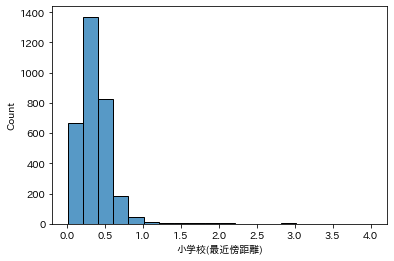

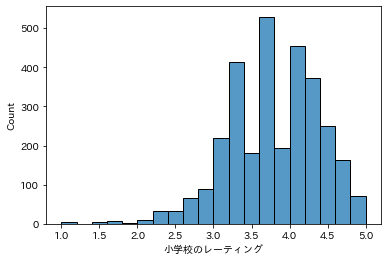

In [18]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [19]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

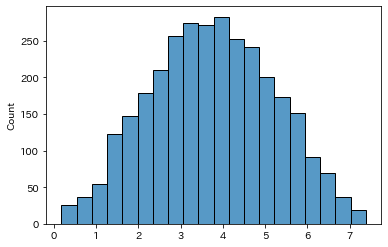

In [20]:
sns.histplot(_tmp_score, bins=20)
plt.show()

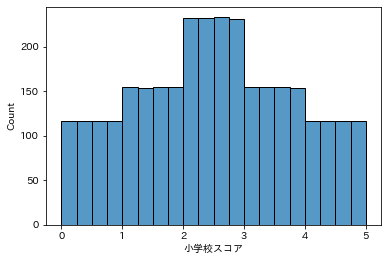

In [21]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

## 中学校スコア

In [22]:
score_name = '中学校スコア'
feature_list = {
    '中学校(最近傍距離)': {'sort': -1, 'weight': 0.5}, 
    '中学校のレーティング': {'sort': 1, 'weight': 1}, 
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

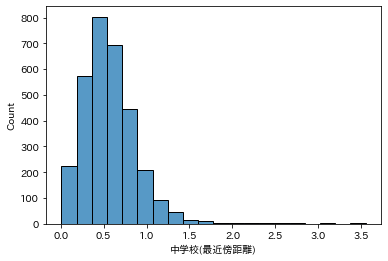

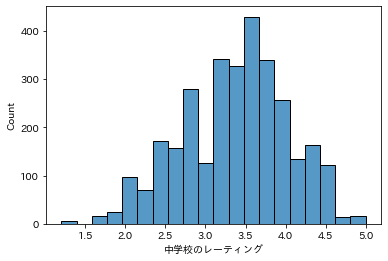

In [23]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [24]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_temp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_temp_score)

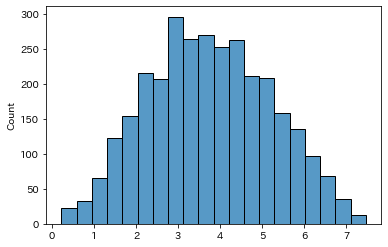

In [25]:
sns.histplot(_temp_score, bins=20)
plt.show()

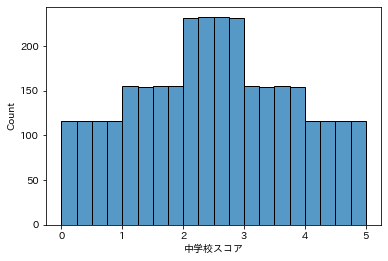

In [26]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

## 幼稚園スコア

In [27]:
score_name = '幼稚園スコア'
feature_list = {
    '幼稚園(最近傍距離)': {'sort': -1, 'weight': 0.5}, 
    '幼稚園のレーティング': {'sort': 1, 'weight': 1}, 
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

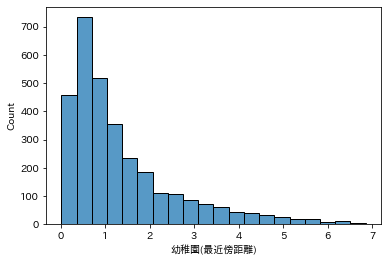

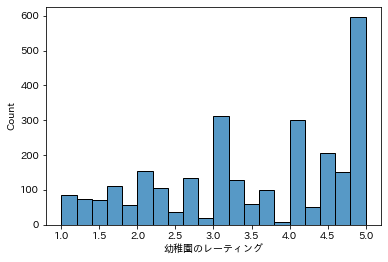

In [28]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [29]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

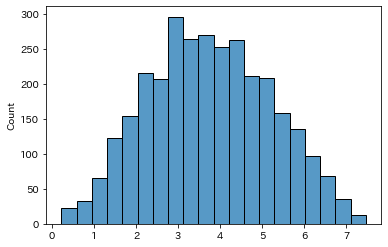

In [30]:
sns.histplot(_temp_score, bins=20)
plt.show()

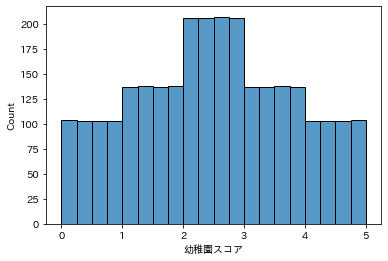

In [31]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

## 保存

In [32]:
all_feature_list

['小学校(最近傍距離)',
 '小学校のレーティング',
 '中学校(最近傍距離)',
 '中学校のレーティング',
 '幼稚園(最近傍距離)',
 '幼稚園のレーティング']

In [33]:
all_score_list

['小学校スコア', '中学校スコア', '幼稚園スコア']

In [34]:
df_pop_master['小学校(最近傍距離)'] = df_pop_master['小学校(最近傍距離)'].round(3)
df_pop_master['中学校(最近傍距離)'] = df_pop_master['中学校(最近傍距離)'].round(3)
df_pop_master['幼稚園(最近傍距離)'] = df_pop_master['幼稚園(最近傍距離)'].round(3)
for col in all_score_list:
    df_pop_master[col] = df_pop_master[col].round(3)

### 保存

In [35]:
df_pop_master[
    ['地域ID'] + all_feature_list + ['最寄りの小学校', '最寄りの中学校', '最寄りの幼稚園'] + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

## 区ごとのスコア確認

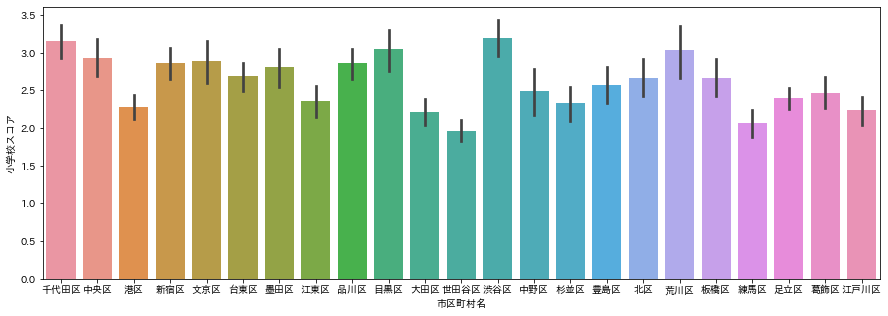

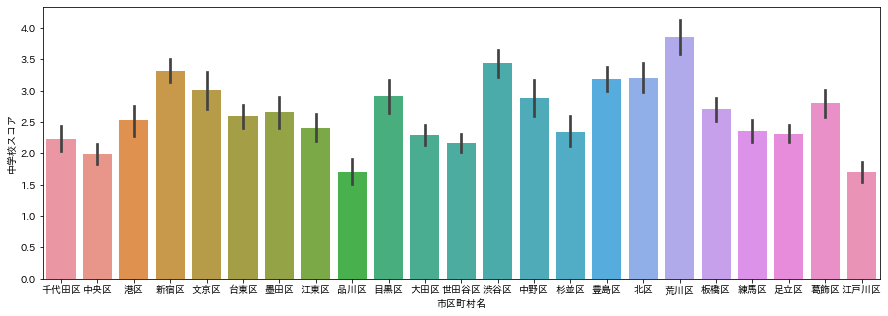

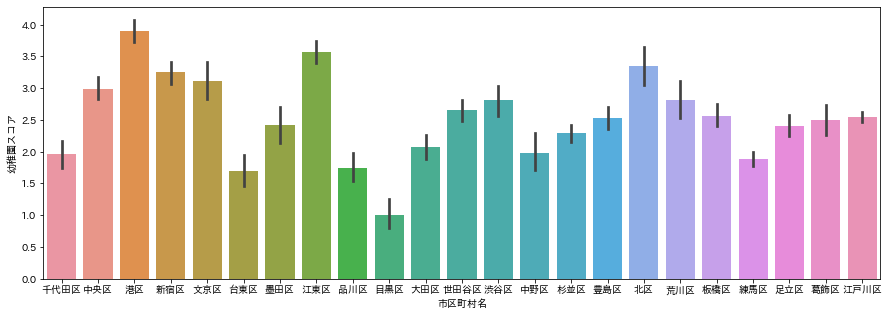

In [36]:
for _score in ['小学校スコア', '中学校スコア', '幼稚園スコア']:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=_score, data=df_pop_master)
    plt.show()

In [44]:
def get_score_top(df_data, target):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + [f'最寄りの{target}', f'{target}(最近傍距離)', f'{target}のレーティング', score_name]
    ].reset_index(drop=True)
    return df_level

In [53]:
df_level = get_score_top(df_pop_master, '小学校')
print(df_level.shape)
df_level.head(10)

(897, 7)


,市区町村名,町名,町丁目,最寄りの小学校,小学校(最近傍距離),小学校のレーティング,小学校スコア
0,新宿区,市谷山伏町,市谷山伏町,新宿区立市谷小学校,0.055,5.0,5.000
1,板橋区,泉町,泉町,板橋区立志村第一小学校,0.068,4.9,4.998
2,大田区,北千束,北千束２丁目,大田区立赤松小学校,0.099,5.0,4.996
3,足立区,西保木間,西保木間４丁目,足立区立西保木間小学校,0.099,5.0,4.994
4,板橋区,向原,向原２丁目,板橋区立向原小学校,0.102,5.0,4.991
5,新宿区,新宿,新宿６丁目,新宿区立天神小学校,0.029,4.8,4.989
6,千代田区,神田司町,神田司町２丁目,千代田区立千代田小学校,0.037,4.8,4.987
7,板橋区,板橋,板橋２丁目,板橋区立板橋第二小学校,0.108,5.0,4.985
8,江戸川区,瑞江,瑞江４丁目,江戸川区立下鎌田西小学校,0.110,5.0,4.983
9,新宿区,中井,中井１丁目,新宿区立落合第五小学校,0.111,5.0,4.981


In [54]:
df_level.tail(10)

,市区町村名,町名,町丁目,最寄りの小学校,小学校(最近傍距離),小学校のレーティング,小学校スコア
887,新宿区,内藤町,内藤町,新宿区立花園小学校,0.437,2.9,0.329
888,新宿区,片町,片町,新宿区立牛込仲之小学校,0.400,2.7,0.308
889,板橋区,蓮沼町,蓮沼町,板橋区立志村第三小学校,0.402,2.7,0.306
890,葛飾区,水元公園,水元公園,葛飾区立東水元小学校,0.372,2.4,0.237
891,江戸川区,興宮町,興宮町,江戸川区立下小岩第二小学校,0.380,1.5,0.196
892,大田区,平和島,平和島４丁目,大田区立大森第五小学校,0.471,2.8,0.189
893,練馬区,上石神井南町,上石神井南町,杉並区立桃井第四小学校,0.710,3.1,0.187
894,練馬区,西大泉町,西大泉町,練馬区立大泉西小学校,0.479,2.6,0.136
895,世田谷区,砧公園,砧公園,世田谷区立用賀小学校,0.852,2.8,0.047
896,大田区,京浜島,京浜島１丁目,大田区立大森第四小学校,1.569,2.5,0.011


In [55]:
df_level = get_score_top(df_pop_master, '中学校')
print(df_level.shape)
df_level.head(10)

(906, 7)


,市区町村名,町名,町丁目,最寄りの中学校,中学校(最近傍距離),中学校のレーティング,中学校スコア
0,中野区,鷺宮,鷺宮４丁目,中野区立第八中学校,0.049,5.0,5.000
1,葛飾区,四つ木,四つ木４丁目,葛飾区立四ツ木中学校,0.080,4.8,4.998
2,葛飾区,水元,水元２丁目,葛飾区立葛美中学校,0.133,5.0,4.996
3,新宿区,北山伏町,北山伏町,新宿区立牛込第一中学校,0.031,4.6,4.994
4,江東区,森下,森下４丁目,江東区立深川第一中学校,0.147,4.6,4.991
5,足立区,柳原,柳原２丁目,足立区立千寿桜堤中学校,0.152,4.6,4.989
6,新宿区,南山伏町,南山伏町,新宿区立牛込第一中学校,0.153,4.6,4.987
7,北区,昭和町,昭和町１丁目,荒川区立第七中学校,0.156,4.6,4.985
8,荒川区,西尾久,西尾久４丁目,荒川区立第七中学校,0.177,4.6,4.983
9,練馬区,東大泉,東大泉６丁目,練馬区立大泉第二中学校,0.115,4.5,4.981


In [56]:
df_level.tail(10)

,市区町村名,町名,町丁目,最寄りの中学校,中学校(最近傍距離),中学校のレーティング,中学校スコア
896,葛飾区,水元公園,水元公園,葛飾区立水元中学校,0.726,2.3,0.201
897,港区,芝浦,芝浦３丁目,港区立三田中学校,0.676,2.1,0.196
898,中央区,日本橋箱崎町,日本橋箱崎町,江東区立深川第二中学校,1.335,2.7,0.173
899,新宿区,三栄町,三栄町,新宿区立四谷中学校,0.703,2.0,0.129
900,新宿区,四谷坂町,四谷坂町,新宿区立四谷中学校,0.732,2.0,0.112
901,新宿区,左門町,左門町,新宿区立四谷中学校,0.746,2.0,0.108
902,千代田区,五番町,五番町,新宿区立四谷中学校,0.804,2.0,0.078
903,新宿区,荒木町,荒木町,新宿区立四谷中学校,0.856,2.0,0.063
904,新宿区,舟町,舟町,新宿区立四谷中学校,0.928,2.0,0.032
905,新宿区,大京町,大京町,新宿区立四谷中学校,1.041,2.0,0.019


In [57]:
df_level = get_score_top(df_pop_master, '幼稚園')
print(df_level.shape)
df_level.head(10)

(851, 7)


,市区町村名,町名,町丁目,最寄りの幼稚園,幼稚園(最近傍距離),幼稚園のレーティング,幼稚園スコア
0,千代田区,六番町,六番町,千代田区立番町幼稚園,0.017,5.0,5.000
1,新宿区,津久戸町,津久戸町,新宿区立津久戸幼稚園,0.035,5.0,4.998
2,江東区,古石場,古石場１丁目,江東区立ちどり幼稚園,0.041,5.0,4.995
3,江東区,亀戸,亀戸２丁目,江東区立第一亀戸幼稚園,0.051,5.0,4.993
4,港区,元麻布,元麻布３丁目,港区立南山幼稚園,0.064,5.0,4.988
5,港区,南麻布,南麻布３丁目,港区立本村幼稚園,0.068,5.0,4.985
6,文京区,小日向,小日向２丁目,文京区立小日向台町幼稚園,0.078,5.0,4.983
7,品川区,西大井,西大井５丁目,品川区立伊藤幼稚園,0.080,5.0,4.981
8,江東区,東砂,東砂４丁目,江東区立東砂幼稚園,0.084,5.0,4.978
9,港区,三田,三田１丁目,港区立赤羽幼稚園,0.094,5.0,4.976


In [58]:
df_level.tail(10)

,市区町村名,町名,町丁目,最寄りの幼稚園,幼稚園(最近傍距離),幼稚園のレーティング,幼稚園スコア
841,渋谷区,南平台町,南平台町,目黒区立ひがしやま幼稚園,1.175,1.00,0.138
842,足立区,古千谷本町,古千谷本町１丁目,荒川区立尾久第二幼稚園,5.982,2.09,0.128
843,渋谷区,鉢山町,鉢山町,目黒区立ひがしやま幼稚園,1.243,1.00,0.107
844,目黒区,祐天寺,祐天寺１丁目,目黒区立ひがしやま幼稚園,1.265,1.00,0.102
845,大田区,大森中,大森中１丁目,品川区立浜川幼稚園,2.957,1.78,0.095
846,渋谷区,円山町,円山町,目黒区立ひがしやま幼稚園,1.395,1.00,0.087
847,渋谷区,松涛,松涛２丁目,目黒区立ひがしやま幼稚園,1.412,1.00,0.085
848,大田区,東蒲田,東蒲田１丁目,品川区立浜川幼稚園,3.683,1.78,0.051
849,大田区,北糀谷,北糀谷１丁目,品川区立浜川幼稚園,3.829,1.78,0.046
850,渋谷区,神山町,神山町,目黒区立ひがしやま幼稚園,1.858,1.00,0.029
